In [37]:
%matplotlib inline
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy

In [38]:
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

In [39]:
air_data = pd.read_csv('D:\\ITMO\\MM_MSA\\Air Quality Benchmark dataset.csv\\Air Quality Benchmark dataset.csv', error_bad_lines=False)
air_data.head()

            Time_stamp boxName  PM 2.5  temp  pressure  humidity  wind_speed  \
0  2018-12-31 18:30:12   iGude   18.20  7.71      1032       100        3.09   
1  2018-12-31 18:32:41   iGude   19.27  7.71      1032       100        3.09   
2  2018-12-31 18:35:11   iGude   18.57  7.71      1032       100        3.09   
3  2018-12-31 18:37:41   iGude   17.85  7.71      1032       100        3.09   
4  2018-12-31 18:40:11   iGude   25.95  7.71      1032       100        3.09   

     Time of Day Peak/NoPeak     Day Week Day Weather Weather Description  \
0  Evening_Hours        Peak  Monday  Workday  Clouds       broken clouds   
1  Evening_Hours        Peak  Monday  Workday  Clouds       broken clouds   
2  Evening_Hours        Peak  Monday  Workday  Clouds       broken clouds   
3  Evening_Hours        Peak  Monday  Workday  Clouds       broken clouds   
4  Evening_Hours        Peak  Monday  Workday  Clouds       broken clouds   

    label  
0  normal  
1  normal  
2  normal  
3  norma

In [25]:
n = len(air_data.index)

In [40]:
def f_kde(data_name):
    
    column = data_name

    # fit density
    model = KernelDensity(bandwidth=2, kernel='gaussian')
    column = column.values.reshape((len(column), 1))
    model.fit(column)

    # sample probabilities for a range of outcomes
    min_amount, max_amount = data_name.min(), data_name.max()
    values = asarray([value for value in range(int(min_amount), int(max_amount))])
    values = values.reshape((len(values), 1))
    probabilities = model.score_samples(values)
    probabilities = exp(probabilities)

    # plot the histogram and pdf
    
    sns.histplot(data_name, kde=False, bins=int(5 * math.log10(len(air_data.index))), stat='density')
    plt.plot(values[:], probabilities, color='r')
"""
plt.figure(figsize = (12, 10))
pyplot.hist(column, bins=int(5 * math.log10(len(air_data.index))), density=True)
pyplot.plot(values[:], probabilities)
pyplot.show()
"""

'\nplt.figure(figsize = (12, 10))\npyplot.hist(column, bins=int(5 * math.log10(len(air_data.index))), density=True)\npyplot.plot(values[:], probabilities)\npyplot.show()\n'

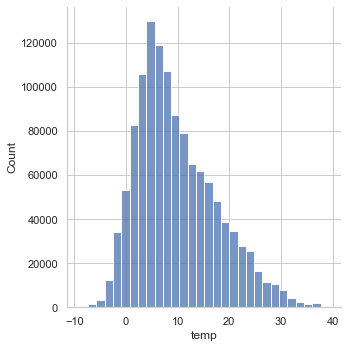

In [47]:
sns.set_theme(style="whitegrid")
temp_hist = sns.displot(air_data.temp, bins = int(5 * math.log10(n)), kde = False)

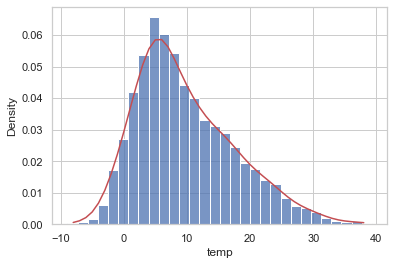

In [48]:
f_kde(air_data.temp)

In [43]:
air_data['temp'].describe()

count    1.230693e+06
mean     9.813300e+00
std      7.726966e+00
min     -8.910000e+00
25%      4.140000e+00
50%      8.200000e+00
75%      1.469000e+01
max      3.928000e+01
Name: temp, dtype: float64

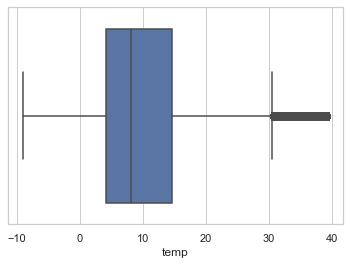

In [44]:
ax = sns.boxplot(x=air_data['temp'])

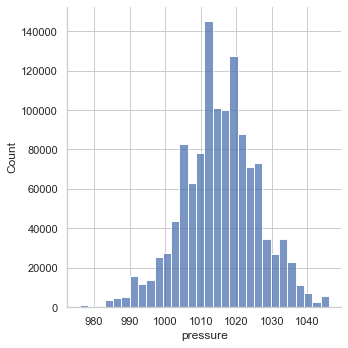

In [45]:
pressure_hist = sns.displot(air_data.pressure, bins = int(5 * math.log10(n)), kde = False)

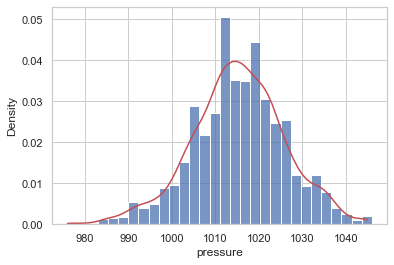

In [46]:
f_kde(air_data.pressure)

In [49]:
descr = air_data['pressure'].describe()
var = air_data['pressure'].var()
trimmed_mean = scipy.stats.trim_mean(air_data['pressure'], proportiontocut=0.1)
mad = scipy.stats.median_abs_deviation(air_data['pressure'], scale='normal')
print("variance: ", var)
print("truncated mean: ", trimmed_mean)
print("MAD: ", mad)
print(descr)

variance:  114.09118026771424
truncated mean:  1015.3581648562041
MAD:  10.378215529539213
count    1.230693e+06
mean     1.015272e+03
std      1.068135e+01
min      9.760000e+02
25%      1.009000e+03
50%      1.015000e+03
75%      1.022000e+03
max      1.046000e+03
Name: pressure, dtype: float64


In [50]:
# Calculation of the 95% confidence interval for the sample mean
mean = air_data['pressure'].mean()
std = air_data['pressure'].std()
norm_q95 = scipy.stats.norm.ppf(0.95)
mean_conf = norm_q95 * std / np.sqrt(len(air_data))


# Calculation of 95% confidence intervals for variance and standard deviation
chi2_q95_left = scipy.stats.chi2.ppf((1 - 0.05 / 2.0), df=len(air_data) - 1)
chi2_q95_right = scipy.stats.chi2.ppf(0.05 / 2.0, df=len(air_data) - 1)

var_conf_left = var * (len(air_data) - 1) / chi2_q95_left
var_conf_right = var * (len(air_data) - 1) / chi2_q95_right
std_conf_left = np.sqrt(var_conf_left)
std_conf_right = np.sqrt(var_conf_right)


print("Sample mean: %0.3f +/- %0.3f" % (mean, mean_conf))
print("95%% Confidence interval of pressure sample variance : (%0.3f; %0.3f)"
      % (var_conf_left, var_conf_right))
print("95%% Confidence interval of pressure sample standard deviation: (%0.3f; %0.3f)"
      % (std_conf_left, std_conf_right))

Sample mean: 1015.272 +/- 0.016
95% Confidence interval of pressure sample variance : (113.807; 114.377)
95% Confidence interval of pressure sample standard deviation: (10.668; 10.695)


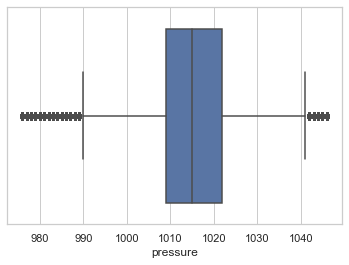

In [53]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=air_data['pressure'])

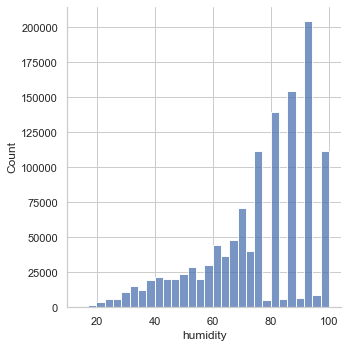

In [53]:
humidity_hist = sns.displot(air_data.humidity, bins = int(5 * math.log10(n)), kde = False)

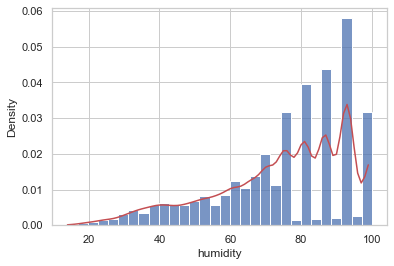

In [54]:
f_kde(air_data.humidity)

In [56]:
air_data['humidity'].describe()

count    1.230693e+06
mean     7.533406e+01
std      1.876159e+01
min      1.400000e+01
25%      6.500000e+01
50%      8.000000e+01
75%      9.200000e+01
max      1.000000e+02
Name: humidity, dtype: float64

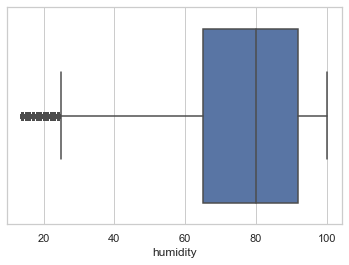

In [57]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=air_data['humidity'])